# **Waste Material Segregation for Improving Waste Management**
## By ANANTHKRISHNA D.S


## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

Load the dataset.

In [ ]:
# Import essential libraries
import os
import shutil
import pandas as pd
import numpy as np
import seaborn as sns

import glob
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

from IPython.display import SVG
import scipy.misc
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
os.mkdir('Waste_Management1') # Creating a directory named "Waste Management"

In [ ]:
# Load and unzip the dataset
import zipfile
import os
filepath = '/content/sample_data/data (1).zip' # a local file path
extract_dir = '/content/Waste_Management1'

try:
    with zipfile.ZipFile(filepath, 'r') as data:
        # Create the extraction directory if it doesn't exist
        #os.makedirs(extract_dir, exist_ok=True)

        # Extract all files and folders to the specified directory
        data.extractall(extract_dir)

    print(f"Successfully extracted '{filepath}' to '{extract_dir}'")


except FileNotFoundError:
    print(f"Error: The zip file '{filepath}' was not found.")
except zipfile.BadZipFile:
    print(f"Error: '{filepath}' is not a valid zip file.")
except Exception as e:
    print(f"An error occurred: {e}")
try:
    with zipfile.ZipFile(filepath, 'r') as data:
        # Create the extraction directory if it doesn't exist
        #os.makedirs(extract_dir, exist_ok=True)

        # Extract all files and folders to the specified directory
        data.extractall(extract_dir)

    print(f"Successfully extracted '{filepath}' to '{extract_dir}'")


except FileNotFoundError:
    print(f"Error: The zip file '{filepath}' was not found.")
except zipfile.BadZipFile:
    print(f"Error: '{filepath}' is not a valid zip file.")
except Exception as e:
    print(f"An error occurred: {e}")


Successfully extracted '/content/sample_data/data (1).zip' to '/content/Waste_Management1'
Successfully extracted '/content/sample_data/data (1).zip' to '/content/Waste_Management1'


In [ ]:
# Load and unzip the dataset

# Where all the image dataset is stored
data_dir = "/content/Waste_Management1/data"

# Training data directory
training_dir = "/content/Waste_Management1/training_data_dir"

# Test data directory
testing_dir = "/content/Waste_Management1/test_data_dir"

# Ratio of training and testing data
train_test_ratio = 0.8


def split_dataset_into_test_and_train_sets(all_data_dir = data_dir, training_data_dir = training_dir, testing_data_dir=testing_dir,
                                           train_test_ratio = 0.8):
    # Recreate testing and training directories

    if not os.path.exists(training_data_dir):
            os.mkdir(training_data_dir)

    if not os.path.exists(testing_data_dir):
            os.mkdir(testing_data_dir)

    num_training_files = 0
    num_testing_files = 0


    for root, dirs, files in os.walk(all_data_dir):

        category_name = os.path.basename(root)

        if category_name == os.path.basename(all_data_dir):
              continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name

        # creating subdir for each sub category
        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)

        file_list = glob.glob(os.path.join(root,'*.png'))


        print(str(category_name) + ' has ' + str(len(files)) + ' images')
        random_set = np.random.permutation((file_list))
        # copy percentage of data from each category to train and test directory
        train_list = random_set[:round(len(random_set)*(train_test_ratio))]
        test_list = random_set[-round(len(random_set)*(1-train_test_ratio)):]



        for lists in train_list :
            shutil.copy(lists, training_data_dir + '/' + category_name + '/' )
            num_training_files += 1

        for lists in test_list :
            shutil.copy(lists, testing_data_dir + '/' + category_name + '/' )
            num_testing_files += 1


    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

In [ ]:
split_dataset_into_test_and_train_sets()

Cardboard has 540 images
Metal has 1000 images
Food_Waste has 1000 images
Paper has 1030 images
Glass has 750 images
Other has 1010 images
Plastic has 2295 images
Processed 6100 training files.
Processed 1525 testing files.


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [ ]:
# Create a function to load the raw images

from tensorflow.keras.preprocessing import image_dataset_from_directory

def raw_images(root_dir, image_size=(256, 256), batch_size=32, validation_split=None, seed=None, labels='inferred',
               label_mode='categorical', class_names=None, color_mode='rgb', interpolation='bilinear'):
  """
  Loads raw images from sub-directories within a root directory using TensorFlow's
  `image_dataset_from_directory`.

  This function is designed to be used in Convolutional Neural Networks (CNNs) or loading and preprocessing image data. It assumes that images are
  organized into subdirectories, where each subdirectory represents a class (labels='inferred').

  Arguments:
    root_dir (str): Path to the root directory containing the subdirectories with image files.
    image_size : The desired height and width of the images after resizing.

    batch_size: Size of the batches of data. Defaults to 32.

    validation_split: Fraction of the data to reserve for validation (between 0 and 1 exclusive).

    seed (int, optional): Random seed for shuffling and transformations.
                          Defaults to None.
    labels: "inferred" (labels are generated from the subdirectory structure)

    label_mode: "categorical" ; for use with `categorical_crossentropy`.

    class_names: list of class names

    color_mode: 'rgb'

    interpolation:  Interpolation method used when resizing. We have used default 'bilinear'.

  Returns:
    tensorflow.python.data.ops.dataset_ops.Dataset: A TensorFlow Dataset object
                                                    containing the loaded and
                                                    preprocessed images
                                                    and their labels.
  """
  # Calling image_dataset_from_directory for loading the images
  ds = image_dataset_from_directory(
      root_dir,
      labels=labels,
      label_mode=label_mode,
      class_names=class_names,
      image_size=image_size,
      batch_size=batch_size,
      validation_split=validation_split,
      seed=seed,
      color_mode=color_mode,
      interpolation=interpolation
  )
  return ds # Return the dataset object


ds = raw_images(data_dir,
                class_names=['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
               )

print("Loaded all data dataset:", ds)
for images, labels in ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Sample labels:", labels.numpy())



Found 7625 files belonging to 7 classes.
Loaded all data dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>
Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 7)
Sample labels: [[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]


In [ ]:
class_names = [
    'Cardboard',
    'Food_Waste',
    'Glass',
    'Metal',
    'Other',
    'Paper',
    'Plastic'
]



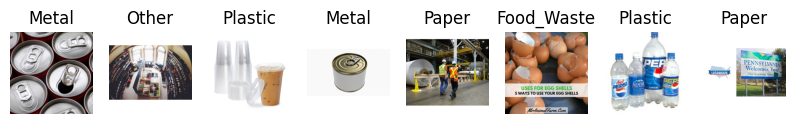

In [ ]:
# Function to plot images and labels

def plot_sample_images(images, labels, class_names, num_images=8):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        # Access the image data from the 'images' argument,
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.binary) # Convert to NumPy array and uint8
        plt.title(class_names[np.argmax(labels[i])]) # Get class index from one-hot encoded labels
        plt.axis('off')
    plt.show()

for images, labels in ds.take(1):
    plot_sample_images(images, labels, class_names, num_images=8)


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [ ]:
# Get the images and their labels

# Done above in 2.2.1

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

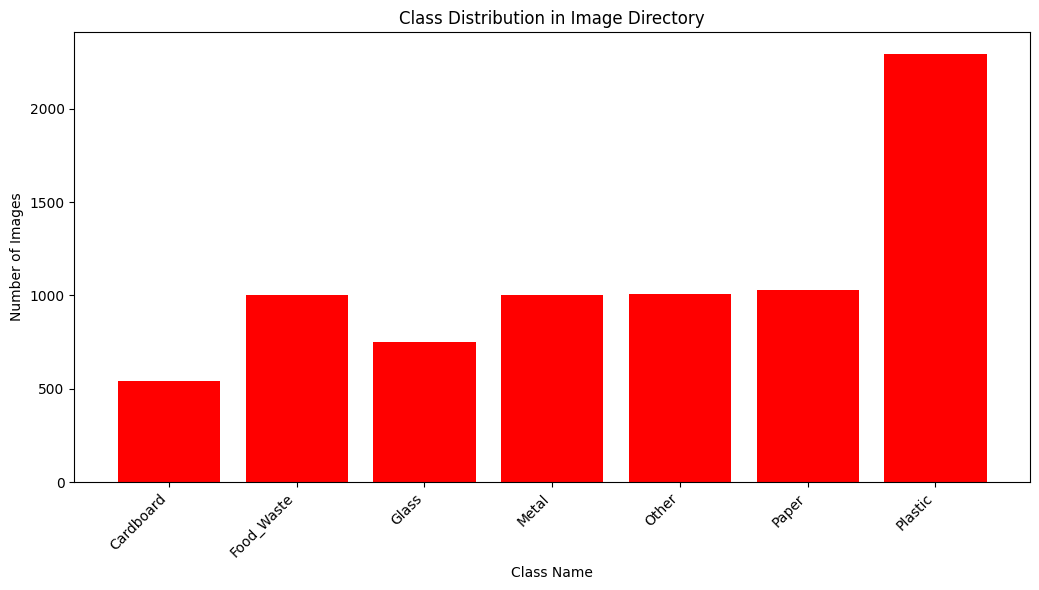

In [ ]:
# Visualise Data Distribution

root_dir = '/content/Waste_Management1/data' ## or root_dir = data_dir

def plot_class_distribution(root_dir):
  """
  Generates a bar plot showing the distribution of classes in an image directory
  structured with subdirectories for each class.

  Args:
    root_dir (str): Path to the root directory containing the subdirectories
                    with image files.
  """
  class_names = sorted(os.listdir(root_dir))
  class_counts = {}

  for class_name in class_names:
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
      image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
      class_counts[class_name] = len(image_files)

  if not class_counts:
    print(f"No subdirectories with image files found in: {root_dir}")
    return

  labels = list(class_counts.keys())
  counts = list(class_counts.values())

  plt.figure(figsize=(len(labels) * 1.5, 6))  # Adjust figure size for better readability
  plt.bar(labels, counts, color='red')
  plt.xlabel("Class Name")
  plt.ylabel("Number of Images")
  plt.title("Class Distribution in Image Directory")
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
  plt.tight_layout()
  plt.show()
  return

plot_class_distribution(root_dir)



#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

In [ ]:
# Visualise Sample Images (across different labels)

# done above in 2.2.1

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [ ]:
# Find the smallest and largest image dimensions from the data set

from PIL import Image

def find_smallest_largest_dimensions(root_dir):
    """
    Finds the smallest and largest image dimensions (width, height)
    from all image files within the specified directory and its subdirectories.

    Arguments:
        root_dir (str): Path to the root directory containing the image files.

    Returns:
        tuple: A tuple containing two tuples:
               - smallest_dims: (width, height) of the smallest image found.
               - largest_dims: (width, height) of the largest image found.
               Returns (None, None) if no image files are found.
    """
    min_width, min_height = float('inf'), float('inf')
    max_width, max_height = 0, 0
    smallest_dims = None
    largest_dims = None
    image_found = False

    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            try:
                img = Image.open(filepath)
                width, height = img.size
                image_found = True

                if width < min_width or height < min_height:
                    min_width, min_height = min(min_width, width), min(min_height, height)
                    smallest_dims = (min_width, min_height)

                if width > max_width or height > max_height:
                    max_width, max_height = max(max_width, width), max(max_height, height)
                    largest_dims = (max_width, max_height)

                img.close()
            except Exception as e:
                print(f"Error opening or reading image: {filepath} - {e}")

    if image_found:
        return smallest_dims, largest_dims
    else:
        return None, None

image_directory = root_dir
smallest, largest = find_smallest_largest_dimensions(image_directory)

if smallest and largest:
  print(f"Smallest image dimensions: {smallest[0]}x{smallest[1]} (width x height)")
  print(f"Largest image dimensions: {largest[0]}x{largest[1]} (width x height)")
else:
  print(f"No valid image files found in: {image_directory}")

Smallest image dimensions: 256x256 (width x height)
Largest image dimensions: 256x256 (width x height)


In [ ]:
# Resize the image dimensions

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_resize_images(directory, target_size):
  """Loads images from a directory, resizes them, and returns them as a NumPy array.

  Arguments:
    directory: The path to the directory containing the images.
    target_size: The desired size for the images (width, height).

  Returns:
    A NumPy array of shape (num_images, target_height, target_width, num_channels).
  """
  images = []
  for root, _, filenames in os.walk(directory):  # Iterate through subdirectories
      for filename in filenames:
          if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
              img_path = os.path.join(root, filename)
              img = load_img(img_path, target_size=target_size)
              img_array = img_to_array(img)
              images.append(img_array)
  return np.array(images)

# Load and resize training images
train_images = load_and_resize_images(training_dir, (256, 256))

# Load and resize testing images
test_images = load_and_resize_images(testing_dir, (256, 256))

print("Training images shape:", train_images.shape)
print("Testing images shape:", test_images.shape)


Training images shape: (6100, 256, 256, 3)
Testing images shape: (1525, 256, 256, 3)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [ ]:
# Encode the labels suitably

def encode_labels_from_directory(root_dir):
  class_names = sorted([dirname for dirname in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, dirname))])
  num_classes = len(class_names)

  # since we have 7 classes
  if num_classes != 7:
    print(f"Warning: The number of subdirectories (classes) found ({num_classes}) is not seven. "
          f"Ensure your directory structure is correct.")

  labels = []
  all_image_paths = []
  for i, class_name in enumerate(class_names):
    class_path = os.path.join(root_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    labels.extend([class_name] * len(image_files))
    all_image_paths.extend([os.path.join(class_path, f) for f in image_files])

  # Initialize LabelEncoder
  from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
  from tensorflow.keras.utils import to_categorical # Import to_categorical
  label_encoder = LabelEncoder()
  label_encoder.fit(class_names)  # Fit on the class names themselves
  integer_encoded = label_encoder.transform(labels)

  # One-hot encode the integer labels
  encoded_labels = to_categorical(integer_encoded, num_classes=num_classes)

  print("Class Names (inferred from subdirectories):", class_names)
  print(f"Total number of images found: {len(all_image_paths)}")
  print(f"Shape of encoded labels: {encoded_labels.shape}")
  print("Example original label:", labels[0])
  print("Example encoded label:", encoded_labels[0])

  return encoded_labels, label_encoder, class_names, all_image_paths


# For train dataset
train_encoded_labels, train_label_encoder, train_class_names, train_image_paths = encode_labels_from_directory(training_dir)

print("For Training set\n")
print("\n--- Encoding Results ---")
print("Encoded Labels (first 5):\n", train_encoded_labels[:5])
print("Label Encoder Classes:", train_label_encoder.classes_)
print("Number of Classes:", len(class_names))
print("First 5 Image Paths:", train_image_paths[:5])


# For test dataset
test_encoded_labels, test_label_encoder, test_class_names, test_image_paths = encode_labels_from_directory(testing_dir)

print("\nFor Test set\n")
print("\n--- Encoding Results ---")
print("Encoded Labels (first 5):\n", test_encoded_labels[:5])
print("Label Encoder Classes:", test_label_encoder.classes_)
print("Number of Classes:", len(class_names))
print("First 5 Image Paths:", test_image_paths[:5])


Class Names (inferred from subdirectories): ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
Total number of images found: 6100
Shape of encoded labels: (6100, 7)
Example original label: Cardboard
Example encoded label: [1. 0. 0. 0. 0. 0. 0.]
For Training set


--- Encoding Results ---
Encoded Labels (first 5):
 [[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]
Label Encoder Classes: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']
Number of Classes: 7
First 5 Image Paths: ['/content/Waste_Management1/training_data_dir/Cardboard/file_385.png', '/content/Waste_Management1/training_data_dir/Cardboard/file_378.png', '/content/Waste_Management1/training_data_dir/Cardboard/file_494.png', '/content/Waste_Management1/training_data_dir/Cardboard/file_312.png', '/content/Waste_Management1/training_data_dir/Cardboard/file_267.png']
Class Names (inferred from subdirectories): ['Car

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [ ]:
# Assign specified parts of the dataset to train and validation sets

# Where all dataset is there. We would split the training dataset in final_training and validation dataset in raio 0.8:0.2
data_dir1 = training_dir

# Final Training data dir
final_training_dir = "/content/Waste_Management1/final_training_data_dir"

# Test data dir
validation_dir = "/content/Waste_Management1/validation_data_dir"

# Ratio of training and validation data
train_val_ratio = 0.8


def split_dataset_into_val_and_train_sets(all_data_dir = data_dir1, final_training_data_dir = final_training_dir,
                                          validation_data_dir=validation_dir, train_val_ratio = 0.8):

    # Recreate validation and final_train directories

    if not os.path.exists(final_training_data_dir):
            os.mkdir(final_training_data_dir)

    if not os.path.exists(validation_data_dir):
            os.mkdir(validation_data_dir)

    num_final_training_files = 0
    num_validation_files = 0


    for root, dirs, files in os.walk(all_data_dir):

        category_name = os.path.basename(root)

        if category_name == os.path.basename(all_data_dir):
              continue

        final_training_data_category_dir = final_training_data_dir + '/' + category_name
        validation_data_category_dir = validation_data_dir + '/' + category_name

        # creating subdir for each sub category
        if not os.path.exists(final_training_data_category_dir):
            os.mkdir(final_training_data_category_dir)

        if not os.path.exists(validation_data_category_dir):
            os.mkdir(validation_data_category_dir)

        file_list = glob.glob(os.path.join(root,'*.png'))


        print(str(category_name) + ' has ' + str(len(files)) + ' images')
        random_set = np.random.permutation((file_list))

        # copy percentage of data from each category to final_train and validation directory
        final_train_list = random_set[:round(len(random_set)*(train_val_ratio))]
        val_list = random_set[-round(len(random_set)*(1-train_val_ratio)):]

        for lists in final_train_list :
            shutil.copy(lists, final_training_data_dir + '/' + category_name + '/' )
            num_final_training_files += 1

        for lists in val_list :
            shutil.copy(lists, validation_data_dir + '/' + category_name + '/' )
            num_validation_files += 1


    print("Processed " + str(num_final_training_files) + " final_training files.")
    print("Processed " + str(num_validation_files) + " validation files.")

split_dataset_into_val_and_train_sets()

Cardboard has 432 images
Metal has 800 images
Food_Waste has 800 images
Paper has 824 images
Glass has 600 images
Other has 808 images
Plastic has 1836 images
Processed 4880 final_training files.
Processed 1220 validation files.


##Data has been split

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [ ]:
# Build and compile the model

# In the following cells

In [ ]:
# Normalize the images for better computational efficiency

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def print_image_sizes(directory):
    #Prints the size of the first image found in each subdirectory.
    print(f"\n--- Image Sizes in: {directory} ---")
    subdirectories = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    if not subdirectories:
        print("No subdirectories found.")
        return

    for subdir in subdirectories:
        subdir_path = os.path.join(directory, subdir)
        image_files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]
        if image_files:
            first_image_path = os.path.join(subdir_path, image_files[0])
            try:
                with Image.open(first_image_path) as img:
                    width, height = img.size
                    print(f"Directory: {subdir}, First Image Size: {width}x{height}")
            except Exception as e:
                print(f"Error opening image in {subdir}: {e}")
        else:
            print(f"Directory: {subdir}, No image files found.")

# Create data generators for training, validation, and testing
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values
val_datagen = ImageDataGenerator(rescale=1./255)    # Normalize pixel values
test_datagen = ImageDataGenerator(rescale=1./255)   # Normalize pixel values

# Flow images from directories
train_generator = train_datagen.flow_from_directory(final_training_dir)
val_generator = val_datagen.flow_from_directory(validation_dir)
test_generator = test_datagen.flow_from_directory(testing_dir)

# Print the target sizes that the generators will produce
print("\n--- Target Sizes for Generators ---")
print(f"Train Generator Target Size: {train_generator.target_size}")
print(f"Validation Generator Target Size: {val_generator.target_size}")
print(f"Test Generator Target Size: {test_generator.target_size}")


# to see the original sizes before resizing (if any)
print_image_sizes(final_training_dir)
print_image_sizes(validation_dir)
print_image_sizes(testing_dir)

Found 4880 images belonging to 7 classes.
Found 1220 images belonging to 7 classes.
Found 1525 images belonging to 7 classes.

--- Target Sizes for Generators ---
Train Generator Target Size: (256, 256)
Validation Generator Target Size: (256, 256)
Test Generator Target Size: (256, 256)

--- Image Sizes in: /content/Waste_Management1/final_training_data_dir ---
Directory: Cardboard, First Image Size: 256x256
Directory: Food_Waste, First Image Size: 256x256
Directory: Glass, First Image Size: 256x256
Directory: Metal, First Image Size: 256x256
Directory: Other, First Image Size: 256x256
Directory: Paper, First Image Size: 256x256
Directory: Plastic, First Image Size: 256x256

--- Image Sizes in: /content/Waste_Management1/validation_data_dir ---
Directory: Cardboard, First Image Size: 256x256
Directory: Food_Waste, First Image Size: 256x256
Directory: Glass, First Image Size: 256x256
Directory: Metal, First Image Size: 256x256
Directory: Other, First Image Size: 256x256
Directory: Paper,

In [ ]:
from tensorflow.keras import layers, models, regularizers

# Define the input shape based on target_size and color mode
input_shape = (256, 256, 3)
num_classes = 7

def build_and_compile_cnn_model(input_shape, num_classes):
    """
    Builds and compiles a CNN model with 3 convolutional layers,
    normalization, dropout, and fully connected layers.

    Arguments:
        input_shape (tuple): The shape of the input images (height, width, channels).
        num_classes (int): The number of output classes.

    Returns:
        tf.keras.Model: The compiled CNN model.
    """
    model = models.Sequential([
        # Convolutional Layer 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Convolutional Layer 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Convolutional Layer 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten the output for the fully connected layers
        layers.Flatten(),

        # Fully Connected Layer 1
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

if __name__ == '__main__':

    model = build_and_compile_cnn_model(input_shape, num_classes)

    # Print the model summary to see the architecture
    model.summary()

    # Now we can train this model using our data generators
    # history = model.fit(train_generator, epochs=..., validation_data=...)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,209,159 (256.38 MB)

 Trainable params: 67,207,687 (256.38 MB)

 Non-trainable params: 1,472 (5.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 45s 201ms/step - accuracy: 0.2749 - loss: 5.1907 - val_accuracy: 0.1385 - val_loss: 5.8056
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.3972 - loss: 4.8788 - val_accuracy: 0.2787 - val_loss: 5.8370
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.4638 - loss: 3.8075 - val_accuracy: 0.2336 - val_loss: 4.2450
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.5207 - loss: 3.3856 - val_accuracy: 0.3402 - val_loss: 4.2626
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - accuracy: 0.5257 - loss: 3.3862 - val_accuracy: 0.3770 - val_loss: 4.0701
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.5602 - loss: 3.4813 - val_accuracy: 0.3303 - val_loss: 4.7787
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.5626 - loss: 3.5508 - val_accuracy: 0.4713 - val_loss: 3.7498
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.6065 - loss: 3

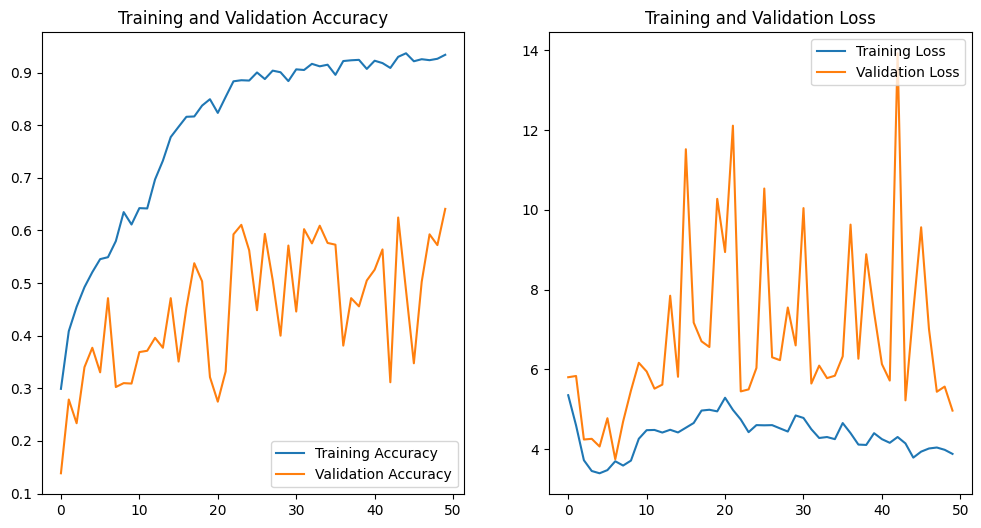

In [ ]:
# Training

# Train the model
epochs = 50  # We can Adjust the number of epochs as needed
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator  # Use validation data since available
)

# visualize the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [ ]:
# Evaluate on the test set; display suitable metrics

img_height, img_width = (256, 256)  # Set to the desired image size
batch_size = 32

# Create data generators for testing
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

results = model.evaluate(test_generator)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])


Found 1525 images belonging to 7 classes.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.6406 - loss: 5.1910
Test Loss: 5.139011383056641
Test Accuracy: 0.6367213129997253


### We will now use transfer learning techniques by using two pre-set models and check for metrics
#### 1- VGG16
#### 2- ResNet50V2

Found 4880 images belonging to 7 classes.
Found 1220 images belonging to 7 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,565,895 (105.16 MB)

 Trainable params: 12,850,183 (49.02 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 56s 285ms/step - accuracy: 0.5146 - loss: 1.5938 - val_accuracy: 0.6566 - val_loss: 1.0311
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.8236 - loss: 0.5182 - val_accuracy: 0.7426 - val_loss: 0.7504
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.9024 - loss: 0.2968 - val_accuracy: 0.7754 - val_loss: 0.7580
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - accuracy: 0.9486 - loss: 0.1834 - val_accuracy: 0.7811 - val_loss: 0.7726
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step - accuracy: 0.9671 - loss: 0.1185 - val_accuracy: 0.7344 - val_loss: 0.9689
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.9733 - loss: 0.1001 - val_accuracy: 0.7574 - val_loss: 0.8728
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.9733 - loss: 0.0956 - val_accuracy: 0.7664 - val_loss: 0.8754
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - accuracy: 0.9877 - loss: 0

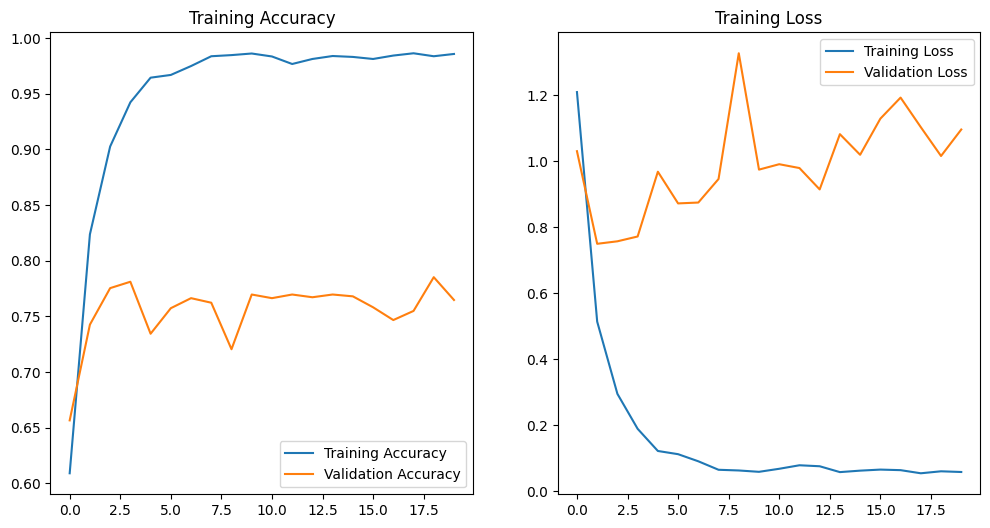

In [ ]:
from tensorflow.keras.applications import VGG16

# Define image dimensions and batch size
img_height, img_width = (224, 224)
batch_size = 32
num_classes = 7

# Building the Transfer Learning Model
def build_transfer_learning_model(input_shape, num_classes):
    # Load the base pre-trained model (VGG16)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freezing the layers of the base model so they are not trainable
    for layer in base_model.layers:
        layer.trainable = False

    # Create the rest of the model on top of the base model
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create data generators for training, validation, and testing with the correct size
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    final_training_dir,
    target_size=(img_height, img_width),  # Resize images to 224x224
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),  # Resize images to 224x224
    batch_size=batch_size,
    class_mode='categorical'
)


# Create the transfer learning model
input_shape = (img_height, img_width, 3)
transfer_learning_model = build_transfer_learning_model(input_shape, num_classes)

# Compile the model
transfer_learning_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

# Print the model summary
transfer_learning_model.summary()

# Train the model
epochs = 20  # We can adjust the number of epochs as needed
history = transfer_learning_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Create data generators for testing with the correct size
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=(img_height, img_width),  # Resize images to 224x224
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluating the model on the test set
results = transfer_learning_model.evaluate(test_generator)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

# Visualizing training history
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,257,991 (187.90 MB)

 Trainable params: 25,692,679 (98.01 MB)

 Non-trainable params: 23,565,312 (89.89 MB)

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 47s 213ms/step - accuracy: 0.6509 - loss: 1.2413 - val_accuracy: 0.8344 - val_loss: 0.5992
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.9045 - loss: 0.2866 - val_accuracy: 0.8475 - val_loss: 0.5336
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.9700 - loss: 0.1204 - val_accuracy: 0.8508 - val_loss: 0.5030
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.9828 - loss: 0.0747 - val_accuracy: 0.8525 - val_loss: 0.5066
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.9897 - loss: 0.0431 - val_accuracy: 0.8590 - val_loss: 0.5303
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9945 - loss: 0.0312 - val_accuracy: 0.8516 - val_loss: 0.5754
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.9949 - loss: 0.0313 - val_accuracy: 0.8492 - val_loss: 0.5886
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9964 - loss: 0

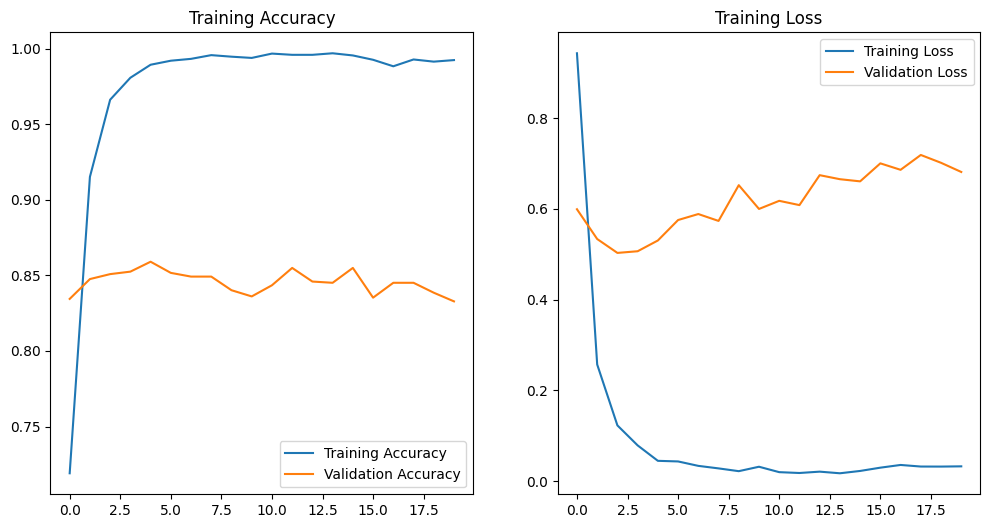

In [ ]:
from tensorflow.keras.applications import ResNet50V2  # Using ResNet50V2

# Define image dimensions and batch size
img_height, img_width = (224, 224)
batch_size = 32
num_classes = 7

# Building the Transfer Learning Model using ResNet50V2
def build_transfer_learning_resnet50(input_shape, num_classes):
    # Loading the base pre-trained model (ResNet50V2)
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freezing the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Creating the rest of the model on top of the base model
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Calling the transfer learning model with ResNet50V2
input_shape = (img_height, img_width, 3)
transfer_learning_resnet_model = build_transfer_learning_resnet50(input_shape, num_classes)

# Compile the model
transfer_learning_resnet_model.compile(optimizer='adam',
                                       loss='categorical_crossentropy',
                                       metrics=['accuracy'])

# Printing the model summary
transfer_learning_resnet_model.summary()

# Training the model
epochs = 20  # We can adjust the number of epochs as needed
history = transfer_learning_resnet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Evaluating the model on the test set
results = transfer_learning_resnet_model.evaluate(test_generator)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

# Visualizing training history
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:

# 1: Create a function to augment the images with parameters:
#rescale=1./255: This is included by default as it's crucial for normalizing pixel values to the 0-1 range, which is generally beneficial for training CNNs.
##rotation_range: Randomly rotates images within the specified degree range.
#width_shift_range: Randomly shifts images horizontally by a fraction of the total width.
#height_shift_range: Randomly shifts images vertically by a fraction of the total height.
#shear_range: Applies a shear transformation, which skews the shape of the image.
#zoom_range: Randomly zooms into or out of the images.
#horizontal_flip: Randomly flips images horizontally.
#fill_mode: Determines how to fill in newly created pixels that might appear after rotations or shifts. 'nearest' is a common and generally good default.

# 2: Then we will create the augmanted training dataset (define training directory) and augmented pipeline with the desired parameters

# 3: Finally would train the model and test on test image set.

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images

def create_augmentation_pipeline(rotation_range=20, width_shift_range=0.2,
                                 height_shift_range=0.2, shear_range=0.2,
                                 zoom_range=0.2, horizontal_flip=True,
                                 fill_mode='nearest'):
    """
    Creates an ImageDataGenerator object configured for data augmentation.

    Args:
        rotation_range (int): Degrees (0-180) for random rotations.
        width_shift_range (float): Fraction of total width for horizontal shift.
        height_shift_range (float): Fraction of total height for vertical shift.
        shear_range (float): Shear Intensity (shear angle in counter-clockwise direction as radians).
        zoom_range (float or [lower, upper]): Range for random zoom. If a float,
                                              [lower=1-zoom_range, upper=1+zoom_range].
        horizontal_flip (bool): Randomly flip inputs horizontally.
        fill_mode (str): Points outside the boundaries of the input are filled
                         according to the given mode ('constant', 'nearest', 'reflect' or 'wrap').

    Returns:
        ImageDataGenerator: An ImageDataGenerator object configured for augmentation.
    """

    datagen = ImageDataGenerator(
        rescale=1./255,  # normalization
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        fill_mode=fill_mode
    )
    return datagen



In [ ]:
# Create the augmented training dataset

if __name__ == '__main__':

    # Define training directory
    final_training_dir = "/content/Waste_Management1/final_training_data_dir"
    img_height, img_width = (256, 256)
    batch_size = 32

    # Create the augmentation pipeline with desired parameters
    train_datagen_augmented = create_augmentation_pipeline(
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='reflect'
    )

    # Create a data generator using the augmentation pipeline
    train_generator_augmented = train_datagen_augmented.flow_from_directory(
        final_training_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )

Found 4880 images belonging to 7 classes.


##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images

# We can now use 'train_generator_augmented' to train your model.
# The images yielded by this generator will be augmented versions
# of the images in our training directory.

print("\nAugmented Training Data Generator created.")
print(f"Target Size: {train_generator_augmented.target_size}")
print(f"Batch Size: {train_generator_augmented.batch_size}")
print(f"Number of Classes: {train_generator_augmented.num_classes}")
print(f"Class Indices: {train_generator_augmented.class_indices}")

# We would then use 'train_generator_augmented' in our model.fit call:
history1 = model.fit(
    train_generator_augmented,
    epochs=50,  # Use the same number of epochs as before
    validation_data=val_generator
)

# For validation and testing, we will only use normalization:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print("\nValidation and Test Data Generators (with only normalization) created.")


Augmented Training Data Generator created.
Target Size: (256, 256)
Batch Size: 32
Number of Classes: 7
Class Indices: {'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}
Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 108s 609ms/step - accuracy: 0.2385 - loss: 5.3729 - val_accuracy: 0.1910 - val_loss: 7.0999
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 120s 536ms/step - accuracy: 0.3244 - loss: 4.5630 - val_accuracy: 0.3033 - val_loss: 4.9100
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 142s 536ms/step - accuracy: 0.3857 - loss: 3.6959 - val_accuracy: 0.3254 - val_loss: 3.4569
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 82s 535ms/step - accuracy: 0.4014 - loss: 3.2418 - val_accuracy: 0.3582 - val_loss: 3.2443
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 82s 534ms/step - accuracy: 0.4168 - loss: 3.0364 - val_accuracy: 0.3418 - val_loss: 3.2985
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 82s 534ms/step - accuracy: 0.4373 - loss: 2.7759 - val_accuracy: 0.4049 - val_loss: 2.8

Found 1525 images belonging to 7 classes.
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.6345 - loss: 4.2422
Test Loss: 4.298348903656006
Test Accuracy: 0.5672131180763245


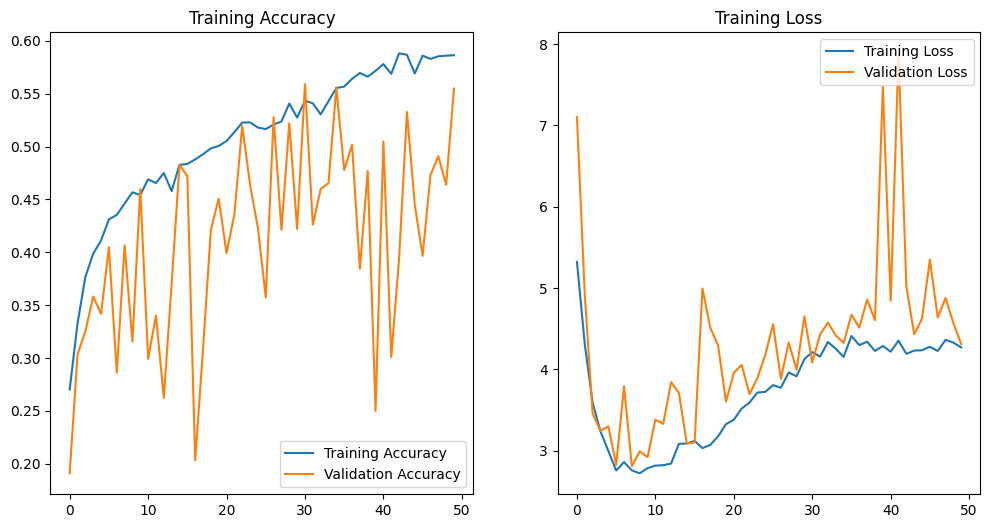

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

results = model.evaluate(test_generator)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

# Visualizing training history
import matplotlib.pyplot as plt

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(len(history1.history['accuracy']))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()


## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* **Report your findings about the data:**
##### 1.The dataset comprises seven categories: 'Cardboard', 'Food Waste', 'Glass', 'Metal', 'Other', 'Paper', and 'Plastic'.
##### 2.The distribution of images across the classes is as follows:

      Cardboard: 540 images

      Metal: 1,000 images

      Food Waste: 1,000 images

      Paper: 1,030 images

      Glass: 750 images

      Other: 1,010 images

      Plastic: 2,295 images
##### 3.It contains a total of 7,625 images.
##### 4.All images are RGB type and have dimensions of 256x256 pixels.

* **Report model training results:**
##### 1.ResNet50V2 as the base model further enhances test set accuracy to 84%.
##### 2.Employing the transformation technique with VGG16 as the base model improves test set accuracy to 76%.
##### 3.The normal convolutional neural network (CNN) model achieves a test set accuracy of only 64%.
##### 4.The loss on the test data decreases in this order: normal CNN model > VGG16 base model > ResNet50V2 base model.
##### 5.Using an augmented dataset results in lower test accuracy, dropping to 57%.
##### 6.Overall, the transformation technique delivers better accuracy on unseen data compared to a regular CNN model.